In [1]:
import sys
sys.path.append('/workspace/Documents')
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.draw import polygon
from scipy.spatial import ConvexHull
from skimage.draw import polygon2mask
from skimage.draw import polygon2mask
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splprep

In [2]:
# function 1: create motion trajectory

def create_motion_trajectory(PSFsize, anxiety, numT, MaxTotalLength, limited_displacement, plot_traj=False):
    # term determining, at each sample, the strengh of the component leating towards the previous position
    centripetal = 0.7 * np.random.rand()

    # term determining, at each sample, the random component of the new direction
    gaussianTerm = 10 * np.random.rand()

    # Generate x(t), Discrete Random Motion Trajectory  in Continuous Domain 
    # v is the initial velocity vector, initialized at random direction
    init_angle = 360 * np.random.rand()
    # initial velocity vector having norm 1
    v0 = v0 = np.cos(np.radians(init_angle)) + 1j * np.sin(np.radians(init_angle))
    # the speed of the initial velocity vector
    v = v0 * MaxTotalLength/(numT-1)

    # Initialize the trajectory vector
    x = np.zeros((numT, 1),dtype=complex)
    TotLength = 0

    for t in range(0,numT - 1):
        while True:
            # Determine the random component motion vector at the next step
            dv = anxiety * (gaussianTerm * (np.random.randn() + 1j * np.random.randn()) - centripetal * x[t]) * (MaxTotalLength / (numT - 1))
            v = v + dv
            
            # Velocity vector normalization
            v = (v / abs(v)) * MaxTotalLength / (numT - 1)

            # not beyond the limited displacement
            if abs(x[t] + v - x[0]) < limited_displacement:
                break
        
        # Update particle position
        x[t + 1] = x[t] + v
        
        # Compute total length
        TotLength = TotLength + abs(x[t + 1] - x[t])
    print(f'Total Length: {TotLength}')

    # center the motion trajectory
    x = x - 1j * np.min(np.imag(x)) - np.min(np.real(x))

    # Center the trajectory
    x = x - 1j * np.remainder(np.imag(x[0]), 1) - np.remainder(np.real(x[0]), 1) + 1 + 1j
    x = x + 1j * np.ceil((PSFsize[0] - np.max(np.imag(x))) / 2) + np.ceil((PSFsize[0] - np.max(np.real(x))) / 2)

    # Plotting
    if plot_traj:
        plt.figure(figsize=(3,3))
        plt.plot(np.real(x), np.imag(x), label='Traj Curve')  # Plot real part vs imaginary part
        plt.plot(np.real(x[0]), np.imag(x[0]), 'rx', label='init')  # Initial point
        plt.plot(np.real(x[-1]), np.imag(x[-1]), 'ro', label='end')  # End point
        plt.axis([0, PSFsize[0], 0, PSFsize[0]])
        plt.legend(fontsize=8, loc='best')
        plt.title(f'anxiety: {anxiety}')
        plt.show()

    # Build structure (Python dictionary as an equivalent to MATLAB struct)
    TrajCurve = {
        'x': x,
        'TotLength': TotLength,
        'Anxiety': anxiety,
        'MaxTotalLength': MaxTotalLength ,
    }
    return TrajCurve

In [184]:
# function 2: create PSF for each exposure time

def create_PSF(TrajCurve, exposure_time, PSFsize, plot_PSF=False):
    PSFnumber = len(exposure_time)
    numt = len(TrajCurve['x'])
    x = TrajCurve['x']

    # Initialize PSFs (for each exposure time)
    PSFS = [np.zeros(PSFsize) for _ in range(PSFnumber)]
    PSF = np.zeros(PSFsize)

    triangle_fun = lambda d: np.maximum(0, (1 - np.abs(d)))
    triangle_fun_prod = lambda d1, d2: triangle_fun(d1) * triangle_fun(d2)

    # Set the exposure time
    T = exposure_time

    for jj in range(len(T)):
        prevT = 0 if jj == 0 else T[jj - 1]
        
        # Sample the trajectory until time T
        for t in range(len(x)):  # For each point in the trajectory
            if (T[jj] * numt >= t + 1) and (prevT * numt < t):
                t_proportion = 1
            elif (T[jj] * numt >= t) and (prevT * numt < t):
                t_proportion = (T[jj] * numt) - t
            elif (T[jj] * numt >= t + 1) and (prevT * numt < t + 1):
                t_proportion = t + 1 - (prevT * numt)
            elif (T[jj] * numt >= t) and (prevT * numt < t + 1):
                t_proportion = (T[jj] - prevT) * numt
            else:
                t_proportion = 0
            
            m2 = min(PSFsize[1] - 1, max(1, np.floor(np.real(x[t]))))
            M2 = m2 + 1
            m1 = min(PSFsize[0] - 1, max(1, np.floor(np.imag(x[t]))))
            M1 = m1 + 1


            # Linear interpolation (separable)
            PSF[int(m1), int(m2)] += t_proportion * triangle_fun_prod(np.real(x[t]) - m2, np.imag(x[t]) - m1)
            PSF[int(m1), int(M2)] += t_proportion * triangle_fun_prod(np.real(x[t]) - M2, np.imag(x[t]) - m1)
            PSF[int(M1), int(m2)] += t_proportion * triangle_fun_prod(np.real(x[t]) - m2, np.imag(x[t]) - M1)
            PSF[int(M1), int(M2)] += t_proportion * triangle_fun_prod(np.real(x[t]) - M2, np.imag(x[t]) - M1)
        
        PSFS[jj] = PSF / len(x)

    if plot_PSF:

        C = np.vstack([np.flip(psf,0) for psf in PSFS])
        # D = np.vstack([psf / np.max(psf) for psf in PSFS])

        # Visualization
        plt.figure(figsize=(5,5))

        # Displaying all PSFs normalized w.r.t. the same maximum
        plt.subplot(1, 1, 1)
        plt.imshow(C, cmap='hot')
        plt.title('All PSF normalized w.r.t. the same maximum', fontsize = 8)

        # # Displaying each PSFs normalized w.r.t. its own maximum
        # plt.subplot(1, 2, 2)
        # plt.imshow(D, cmap='hot')
        # plt.title('Each PSFs normalized w.r.t. its own maximum', fontsize = 8)
        # plt.show()

    return PSFS


In [3]:
# function 3: create final blurred image
def create_motion_blur_img(img,PSFS, add_noise = False, sigma_gauss = None):
    if add_noise is True:
        assert sigma_gauss is not None , 'Please provide the value of sigma_gauss'

    final_img = np.zeros([img.shape[0], img.shape[1], len(PSFS)])
    for i in range(len(PSFS)):
        psf = PSFS[i]
        y = np.copy(img)

        # Get the size of the original image and PSF
        yN, xN = y.shape
        ghy, ghx = psf.shape

        # Pad PSF with zeros to whole image domain, and centers it
        big_v = np.zeros((yN, xN))
        big_v[:ghy, :ghx] = psf
        big_v = np.roll(big_v, -round((ghy-1)/2), axis=0)
        big_v = np.roll(big_v, -round((ghx-1)/2), axis=1)

        # Frequency response of the PSF
        V = np.fft.fft2(big_v)

        # Performs blurring (convolution is obtained by product in frequency domain)
        y_blur = np.real(np.fft.ifft2(V * np.fft.fft2(y)))

        if add_noise is False:
            final_img[:,:,i] = np.copy(y_blur)
        else:
            # Add noise terms
            # Poisson Noise (signal and time dependent)
            # Ensure y_blur is non-negative as poisson noise is defined for non-negative values
            y_blur_positive = np.clip(y_blur, 0, None)
            raw = np.random.poisson(y_blur_positive)

            # Gaussian Noise (signal and image independent)
            final_img = raw + sigma_gauss * np.random.randn(*raw.shape)
    return final_img

In [209]:
# function 4: create a random ROI
def create_random_ROI(original_image, plot_ROI=False):

    image = np.zeros(original_image.shape, dtype=np.uint8)


    m = int(np.random.uniform(image.shape[0]//2 - 50, image.shape[0]//2 + 50))
    n = int(np.random.uniform(image.shape[1]//2 - 50, image.shape[1]//2 + 50))

    num_vertices = int(np.random.uniform(5,20)) 
    radius = np.random.uniform(100,200)
    angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    dx = radius * np.cos(angles) + np.random.normal(0, 30, num_vertices)
    dy = radius * np.sin(angles) + np.random.normal(0, 30, num_vertices)

    x_vertices = np.clip(n + dx, 0, image.shape[1]-1).astype(int)
    y_vertices = np.clip(m + dy, 0, image.shape[0]-1).astype(int)

    rr, cc = polygon(y_vertices, x_vertices)

    image[rr, cc] = 1
    image_raw = image.copy()
    image = (image ).astype(np.uint8) * 255

    # convex hull
    x_indices, y_indices = np.where(image == 255)
    points = np.vstack((x_indices, y_indices)).T
    hull = ConvexHull(points)
    hull_vertices = points[hull.vertices]
    image_shape = image.shape
    convex_hull_mask = polygon2mask(image_shape, hull_vertices)

    # smooth the mask
    x, y = hull_vertices.T
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    tck, u = splprep([x, y], s=10, per=True)
    new_points = splev(np.linspace(0, 1, 1000), tck)
    smooth_mask = polygon2mask(image_shape, np.array(new_points).T)


    if plot_ROI:
        plt.figure(figsize = (6,2))
        plt.subplot(131); plt.imshow(image_raw, 'gray')
        plt.subplot(132); plt.imshow(convex_hull_mask, 'gray')
        plt.subplot(133); plt.imshow(smooth_mask, 'gray')
    return smooth_mask

img shape: (468, 500)


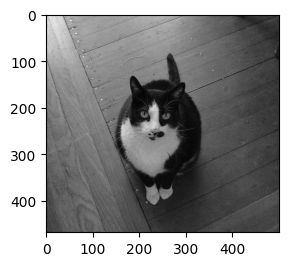

In [4]:
# Load the image
image_path = '/workspace/Documents/PSF_generation/imgs/000215_gray.jpg'
img = cv2.imread(image_path)[:,:,0]
print('img shape:', img.shape)
plt.figure(figsize = (3,3))
plt.subplot(111); plt.imshow(img, 'gray')

In [154]:
# set some simulation parameters
PSFsize = [32,32]
anxiety = 0.05 # what's this?
numT = 2000# the number of steps the motion trajectory should be sampled
limited_displacement = 15 
MaxTotalLength = 200

exposure_time = [0.5,1]

# noise paramters
sigma_gauss = 0.05

Total Length: [200.]


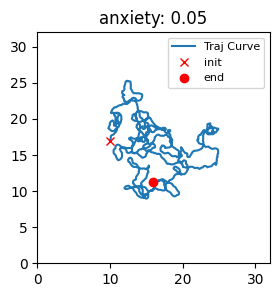

In [151]:
# create motion trajectory
TrajCurve = create_motion_trajectory(PSFsize, anxiety, numT, MaxTotalLength,limited_displacement, plot_traj=True)

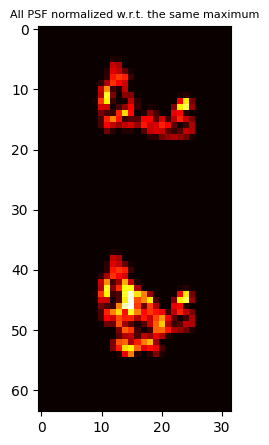

In [185]:
# create PSF for each exposure time
PSFS = create_PSF(TrajCurve, exposure_time, PSFsize, plot_PSF=True)

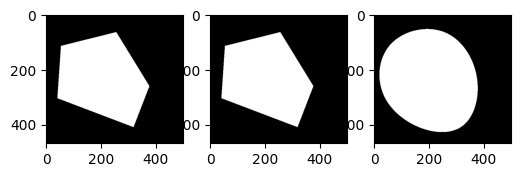

In [210]:
# create a random ROI
ROI = create_random_ROI(img, plot_ROI=True)

Text(0.5, 1.0, 'Blurred Image with ROI')

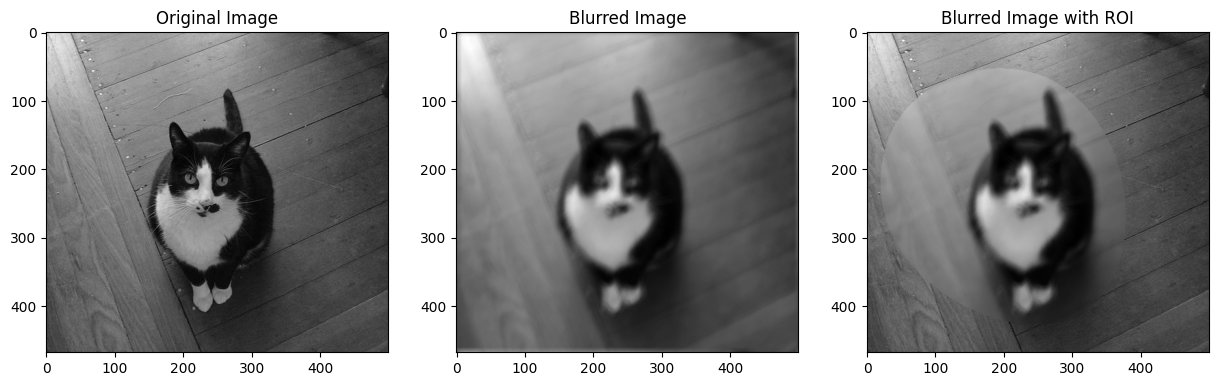

In [212]:
# create final blurred image
final_img = create_motion_blur_img(img, PSFS, add_noise=False, sigma_gauss=sigma_gauss)[:,:,1]
# scale the final image so that keep the intensity range same
final_img = (final_img - np.min(final_img)) / (np.max(final_img) - np.min(final_img)) * (np.max(img) - np.min(img)) + np.min(img)

# some chances that only part of the image is blurred
if np.random.rand() > 0.67:
    final_img_roi = np.copy(img)
    final_img_roi[ROI] = final_img[ROI]
else:
    print('no ROI')
    final_img_roi = final_img

plt.figure(figsize = (15,5))
plt.subplot(131); plt.imshow(img, 'gray')
plt.title('Original Image')
plt.subplot(132); plt.imshow(final_img, 'gray')
plt.title('Blurred Image')
plt.subplot(133); plt.imshow(final_img_roi, 'gray')
plt.title('Blurred Image with ROI')
